# Commissioning Instrument Camera Locations

As derived by Stephen, to be compared with derivations from Ashley and Aaron

CI geometry from [DESI-3347](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=3347)

In [1]:
%pylab inline
import numpy as np
from astropy.table import Table
import desimodel.focalplane
import desimodel.io

Populating the interactive namespace from numpy and matplotlib


## Basic data from DESI-3347

In [2]:
#- Rotation of each SBIG camera relative to CS5 (page 2)
rot = dict(
    C1 = -90.0,
    C2 = 180.0,
    C3 = 180.0,
    C4 = 0.0,
    C5 = +90.0
)
#- x locations of the camera centers in CS5 (page 3)
xloc = dict(
    C1 = -398.55,
    C2 = 0.0,
    C3 = 0.0,
    C4 = 0.0,
    C5 = 398.55
)
#- y locations of the camera centers in CS5 (page 3)
#- (sign flip for y due to CS6 -> CS5)
yloc = dict(
    C1 = 0.0,
    C2 = 398.55,
    C3 = 0.0,
    C4 = -398.55,
    C5 = 0.0,
)
#- Number of pixels in x and y (page 2)
npix_x = 3072
npix_y = 2048
pixsize = 9e-3  #- 9 microns -> mm

## Convert to GFA corners format

In [3]:
def xyzrot(axis, v, theta):
    '''Rotate `v [x,y,z]` counter-clockwise around `axis` by `theta` in radians'''
    
    #- From https://stackoverflow.com/questions/6802577/rotation-of-3d-vector
    #- Uses Euler-Rodrigues formula for constructing 3D rotation matrix
    def rotation_matrix(axis, theta):
        """
        Return the rotation matrix associated with counterclockwise rotation about
        the given axis by theta radians.
        """
        axis = np.asarray(axis)
        axis = axis / np.sqrt(np.dot(axis, axis))
        a = math.cos(theta / 2.0)
        b, c, d = -axis * math.sin(theta / 2.0)
        aa, bb, cc, dd = a * a, b * b, c * c, d * d
        bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
        return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                         [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                         [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

    return np.dot(rotation_matrix(axis, theta), v)

def xyrot(x, y, degrees):
    '''2D rotation of x,y by degrees'''
    a = np.radians(degrees)
    R = np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])
    v = np.array([x, y])
    return R.dot(v)

In [4]:
#- Interpolation functions between s, r, and z, including extrapolation to 0, using positioner location file
from scipy.interpolate import interp1d
fp = desimodel.io.load_deviceloc()
fp = fp[fp['PETAL']==0]
fp_s = np.concatenate([[0.0,], fp['S']])
fp_z = np.concatenate([[0.0,], fp['Z']])
fp_r = np.concatenate([[0.0,], np.sqrt(fp['X']**2 + fp['Y']**2)])
s2z = interp1d(fp_s, fp_z, kind='quadratic', assume_sorted=False)
r2z = interp1d(fp_r, fp_z, kind='quadratic', assume_sorted=False)

#- Corners before rotation and offset
dx = npix_x*pixsize
dy = npix_y*pixsize
xc = (-dx/2, +dx/2, +dx/2, -dx/2)
yc = (-dy/2, -dy/2, +dy/2, +dy/2)

#- Data table to fill
gfatable = Table(names = ('GFA_LOC', 'CORNER', 'X', 'Y', 'Z', 'Q', 'S', 'RADIUS_DEG'),
             dtype = ('int', 'int', 'float', 'float', 'float', 'float', 'float', 'float'))

for i, cam in enumerate(('C1', 'C2', 'C3', 'C4', 'C5')):
    #- Rotate camera
    xx, yy = xyrot(xc, yc, rot[cam])
    zz = np.zeros(4)
    
    #- Tilt camera to be parallel to focal surface at xloc, yloc
    rloc = np.sqrt(xloc[cam]**2 + yloc[cam]**2)
    if rloc > 0.5:
        dzdr = r2z(rloc+0.5) - r2z(rloc-0.5)
        theta = -np.arctan2(dzdr, 1.0)
        #- Axis about which to rotate; doesn't have to be normalized
        axis = [-yloc[cam], xloc[cam], 0.0]
        xr, yr, zr = xyzrot(axis, [xx, yy, zz], theta)
    else:
        #- Treat central camera as unrotated
        xr, yr, zr = xx, yy, zz

    #- Offset to xy center of camera
    xr += xloc[cam]
    yr += yloc[cam]
    
    #- Offset in z to be tangent to focal surface
    rloc = np.sqrt(xloc[cam]**2 + yloc[cam]**2)
    zr += r2z(rloc)

    #- Update Q,S,R for final X,Y locations
    qq, ss = desimodel.focalplane.xy2qs(xr, yr)
    rr = desimodel.focalplane.get_radius_deg(xr, yr)
    for j in range(len(xx)):
        gfatable.add_row([i+1, j, xr[j], yr[j], zr[j], qq[j], ss[j], rr[j]])

gfatable

<Table length=20>
GFA_LOC CORNER       X        ...       Q             S          RADIUS_DEG  
 int64  int64     float64     ...    float64       float64        float64    
------- ------ -------------- ... ------------- ------------- ---------------
      1      0 -407.724682017 ... 178.058117173 408.544082773   1.60749504366
      1      1 -407.724682017 ... 181.941882827 408.544082773   1.60749504366
      1      2 -389.375317983 ... 182.033319228 390.122983026   1.54069915922
      1      3 -389.375317983 ... 177.966680772 390.122983026   1.54069915922
      2      0         13.824 ... 88.0581171727 408.544082773   1.60749504366
      2      1        -13.824 ... 91.9418828273 408.544082773   1.60749504366
      2      2        -13.824 ... 92.0333192279 390.122983026   1.54069915922
      2      3         13.824 ... 87.9666807721 390.122983026   1.54069915922
      3      0         13.824 ...  33.690067526 16.6143818705 0.0683595477254
      3      1        -13.824 ... 146.309932474 16.6143818705 0.0683595477254
      3      2        -13.824 ... 213.690067526 16.6143818705 0.0683595477254
      3      3         13.824 ... 326.309932474 16.6143818705 0.0683595477254
      4      0        -13.824 ... 268.058117173 408.544082773   1.60749504366
      4      1         13.824 ... 271.941882827 408.544082773   1.60749504366
      4      2         13.824 ... 272.033319228 390.122983026   1.54069915922
      4      3        -13.824 ... 267.966680772 390.122983026   1.54069915922
      5      0  407.724682017 ... 358.058117173 408.544082773   1.60749504366
      5      1  407.724682017 ... 1.94188282729 408.544082773   1.60749504366
      5      2  389.375317983 ... 2.03331922792 390.122983026   1.54069915922
      5      3  389.375317983 ... 357.966680772 390.122983026   1.54069915922

## Visualize

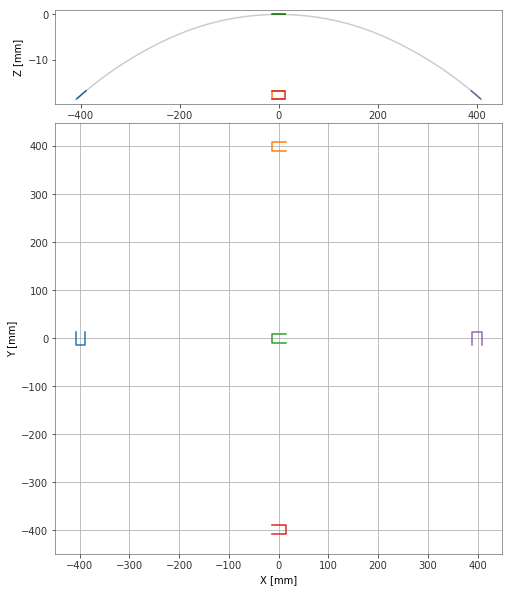

In [5]:
figure(figsize=(8,10))
ax1 = subplot2grid((5,1), (0, 0))
ax2 = subplot2grid((5,1), (1, 0), rowspan=4)

for cam in np.arange(5)+1:
    ii = gfatable['GFA_LOC'] == cam
    xx = gfatable['X'][ii]
    yy = gfatable['Y'][ii]
    zz = gfatable['Z'][ii]
    ax1.plot(xx, zz)
    ax2.plot(xx, yy)

rr = np.linspace(-410, 410, 100)
zz = r2z(np.abs(rr))
ax1.plot(rr, zz, color='k', alpha=0.2)
# xlabel('x [mm]'); ylabel('z [mm]')

ax1.set_ylabel('Z [mm]')
ax2.set_xlabel('X [mm]')
ax2.set_ylabel('Y [mm]')
ax2.grid()

### also look at x,y and RA,dec to check signs

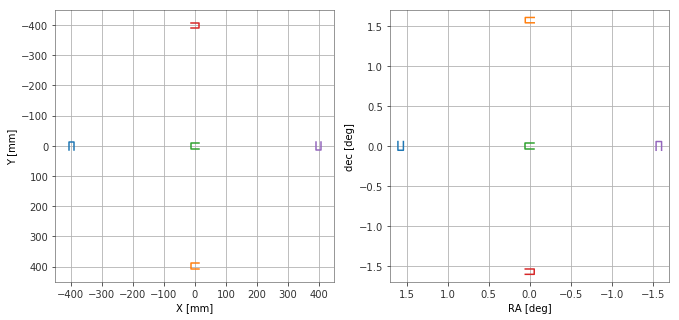

In [6]:
#- Plot them with rotations and offsets
figure(figsize=(11,5))
ax1 = subplot(121)
ax2 = subplot(122)

for cam in np.arange(5)+1:
    ii = gfatable['GFA_LOC'] == cam
    xx = gfatable['X'][ii]
    yy = gfatable['Y'][ii]
    ax1.plot(xx, yy)
    
    ra, dec = desimodel.focalplane.xy2radec(0, 0, xx, yy)
    ra[ra>180] -= 360
    ax2.plot(ra, dec)

ax1.set_xlim(-450, 450); ax1.set_ylim(450, -450); ax1.grid()
ax1.set_xlabel('X [mm]'); ax1.set_ylabel('Y [mm]')

ax2.set_xlim(1.7, -1.7); ax2.set_ylim(-1.7, 1.7); ax2.grid()
ax2.set_xlabel('RA [deg]'); ax2.set_ylabel('dec [deg]')
None

## Output

In [7]:
gfatable.write('ci.ecsv', overwrite=True)

In [8]:
!cat ci.ecsv

# %ECSV 0.9
# ---
# datatype:
# - {name: GFA_LOC, datatype: int64}
# - {name: CORNER, datatype: int64}
# - {name: X, datatype: float64}
# - {name: Y, datatype: float64}
# - {name: Z, datatype: float64}
# - {name: Q, datatype: float64}
# - {name: S, datatype: float64}
# - {name: RADIUS_DEG, datatype: float64}
# schema: astropy-2.0
GFA_LOC CORNER X Y Z Q S RADIUS_DEG
1 0 -407.724682017 13.824 -18.6883200891 178.058117173 408.544082773 1.60749504366
1 1 -407.724682017 -13.824 -18.6883200891 181.941882827 408.544082773 1.60749504366
1 2 -389.375317983 -13.824 -16.9449143658 182.033319228 390.122983026 1.54069915922
1 3 -389.375317983 13.824 -16.9449143658 177.966680772 390.122983026 1.54069915922
2 0 13.824 407.724682017 -18.6883200891 88.0581171727 408.544082773 1.60749504366
2 1 -13.824 407.724682017 -18.6883200891 91.9418828273 408.544082773 1.60749504366
2 2 -13.824 389.375317983 -16.9449143658 92.0333192279 390.122983026 1.54069915922
2 3 13.824 389.375317983 -16.9449143658 87.9666807

## How to use this

In [9]:
ci = desimodel.focalplane.gfa.GFALocations(gfatable)

In [10]:
n = 50000
ra = np.random.uniform(-2, 2, size=n)
dec = np.random.uniform(-2, 2, size=n)
targets = Table(dict(RA=ra, DEC=dec))

citargets = ci.targets_on_gfa(telra=0.0, teldec=0.0, targets=targets)

Text(0,0.5,'dec [deg]')

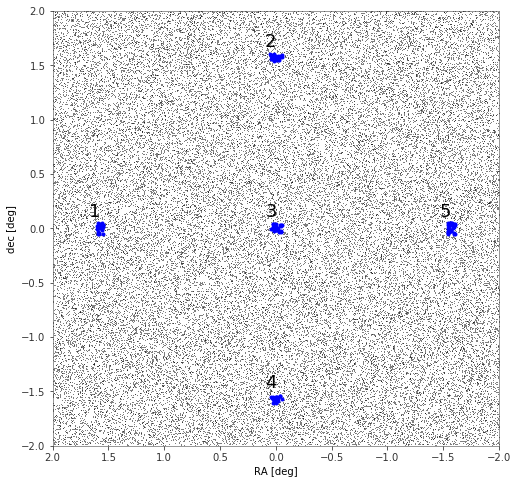

In [11]:
figure(figsize=(8,8))
plot(targets['RA'], targets['DEC'], 'k,', alpha=0.5)
plot(citargets['RA'], citargets['DEC'], 'b.')
for cam in [1,2,3,4,5]:
    ii = citargets['GFA_LOC'] == cam
    x = np.mean(citargets['RA'][ii])
    y = np.mean(citargets['DEC'][ii])
    text(x+0.1, y+0.1, str(cam), fontsize=18)

xlim(2, -2); ylim(-2, 2)
xlabel('RA [deg]'); ylabel('dec [deg]')

## Bokeh visualization for zooming / interactivity

In [12]:
import bokeh.plotting as bk
from bokeh.models import Range1d
bk.output_notebook()

Loading BokehJS ...

In [13]:
fig = bk.figure()
fig.scatter(targets['RA'], targets['DEC'], size=0.5)
fig.scatter(citargets['RA'], citargets['DEC'], size=2, color='red')

for cam in [1,2,3,4,5]:
    ii = citargets['GFA_LOC'] == cam
    x = np.mean(citargets['RA'][ii])
    y = np.mean(citargets['DEC'][ii])
    fig.text([x+0.1,], [y+0.1,], text=[str(cam),])

fig.xaxis.axis_label = 'RA [deg]'
fig.yaxis.axis_label = 'dec [deg]'
fig.x_range = Range1d(2, -2)
fig.y_range = Range1d(-2, 2)

bk.show(fig)

## Compare to Ashley's corners

It appears that Ashley's old calculation matched Stephen's old calculation, which did not account for the
changes to x,y due to the CCD tilt to be tangent to the focal surface.

In [20]:
#- Original from Ashley:
'''
#GFA_LOC, Q0, Q1, Q2, Q3, S0, S1, S2, S3
0 (-1.6035616,-0.0546048) (-1.6035616,0.0546048) (-1.5364384,-0.0546048) (-1.5364384,0.0546048)  (-407.766,-13.824) (-407.766,13.824) (-389.334,-13.824) (-389.334,13.824) 
1 (0.0546253064629,-1.6035616) (0.0546253064629,-1.5364384) (-0.0546253064629,-1.6035616) (-0.0546253064629,-1.5364384)  (13.824,-407.766) (13.824,-389.334) (-13.824,-407.766) (-13.824,-389.334) 
2 (0.0568704,-0.0379136) (0.0568704,0.0379136) (-0.0568704,-0.0379136) (-0.0568704,0.0379136)  (13.824,-9.216) (13.824,9.216) (-13.824,-9.216) (-13.824,9.216) 
3 (-0.0546253064629,1.6035616) (-0.0546253064629,1.5364384) (0.0546253064629,1.6035616) (0.0546253064629,1.5364384)  (-13.824,407.766) (-13.824,389.334) (13.824,407.766) (13.824,389.334) 
4 (1.6035616,0.0546048) (1.6035616,-0.0546048) (1.5364384,0.0546048) (1.5364384,-0.0546048)  (407.766,13.824) (407.766,-13.824) (389.334,13.824) (389.334,-13.824)
'''

#- Hand edited to pick out just the x,y corners and make it python parseable
xy = dict()
xy['C1'] = [(-407.766,-13.824), (-407.766,13.824), (-389.334,-13.824), (-389.334,13.824)] 
xy['C2'] = [(13.824,-407.766), (13.824,-389.334), (-13.824,-407.766), (-13.824,-389.334)]
xy['C3'] = [(13.824,-9.216), (13.824,9.216), (-13.824,-9.216), (-13.824,9.216)] 
xy['C4'] = [(-13.824,407.766), (-13.824,389.334), (13.824,407.766), (13.824,389.334)]
xy['C5'] = [(407.766,13.824), (407.766,-13.824), (389.334,13.824), (389.334,-13.824)]

citable = Table(names = ('GFA_LOC', 'CORNER', 'X', 'Y', 'Z', 'Q', 'S', 'RADIUS_DEG'),
             dtype = ('int', 'int', 'float', 'float', 'float', 'float', 'float', 'float'))

for icam in range(5):
    cam = 'C'+str(icam+1)
    for corner in range(4):
        x = xy[cam][corner][0]
        y = xy[cam][corner][1]
        r = np.sqrt(x**2 + y**2)
        z = r2z(r)
        q, s = desimodel.focalplane.xy2qs(x, y)
        citable.add_row([icam+1, corner, x, y, z, q, s, r])

In [21]:
citable  #- Ashley's numbers, matches Stephen's old calculation

<Table length=20>
GFA_LOC CORNER    X        Y     ...       Q             S         RADIUS_DEG 
 int64  int64  float64  float64  ...    float64       float64       float64   
------- ------ -------- -------- ... ------------- ------------- -------------
      1      0 -407.766  -13.824 ... 181.941686211 408.585575734 408.000261926
      1      1 -407.766   13.824 ... 178.058313789 408.585575734 408.000261926
      1      2 -389.334  -13.824 ... 182.033534832 390.081516682 389.579345618
      1      3 -389.334   13.824 ... 177.966465168 390.081516682 389.579345618
      2      0   13.824 -407.766 ... 271.941686211 408.585575734 408.000261926
      2      1   13.824 -389.334 ... 272.033534832 390.081516682 389.579345618
      2      2  -13.824 -407.766 ... 268.058313789 408.585575734 408.000261926
      2      3  -13.824 -389.334 ... 267.966465168 390.081516682 389.579345618
      3      0   13.824   -9.216 ... 326.309932474 16.6143818705 16.6143802773
      3      1   13.824    9.216 ...  33.690067526 16.6143818705 16.6143802773
      3      2  -13.824   -9.216 ... 213.690067526 16.6143818705 16.6143802773
      3      3  -13.824    9.216 ... 146.309932474 16.6143818705 16.6143802773
      4      0  -13.824  407.766 ... 91.9416862114 408.585575734 408.000261926
      4      1  -13.824  389.334 ... 92.0335348323 390.081516682 389.579345618
      4      2   13.824  407.766 ... 88.0583137886 408.585575734 408.000261926
      4      3   13.824  389.334 ... 87.9664651677 390.081516682 389.579345618
      5      0  407.766   13.824 ... 1.94168621143 408.585575734 408.000261926
      5      1  407.766  -13.824 ... 358.058313789 408.585575734 408.000261926
      5      2  389.334   13.824 ...  2.0335348323 390.081516682 389.579345618
      5      3  389.334  -13.824 ... 357.966465168 390.081516682 389.579345618

In [22]:
gfatable  #- New calculation, including corrections to x,y for the CCD tilts

<Table length=20>
GFA_LOC CORNER       X        ...       Q             S          RADIUS_DEG  
 int64  int64     float64     ...    float64       float64        float64    
------- ------ -------------- ... ------------- ------------- ---------------
      1      0 -407.724682017 ... 178.058117173 408.544082773   1.60749504366
      1      1 -407.724682017 ... 181.941882827 408.544082773   1.60749504366
      1      2 -389.375317983 ... 182.033319228 390.122983026   1.54069915922
      1      3 -389.375317983 ... 177.966680772 390.122983026   1.54069915922
      2      0         13.824 ... 88.0581171727 408.544082773   1.60749504366
      2      1        -13.824 ... 91.9418828273 408.544082773   1.60749504366
      2      2        -13.824 ... 92.0333192279 390.122983026   1.54069915922
      2      3         13.824 ... 87.9666807721 390.122983026   1.54069915922
      3      0         13.824 ...  33.690067526 16.6143818705 0.0683595477254
      3      1        -13.824 ... 146.309932474 16.6143818705 0.0683595477254
      3      2        -13.824 ... 213.690067526 16.6143818705 0.0683595477254
      3      3         13.824 ... 326.309932474 16.6143818705 0.0683595477254
      4      0        -13.824 ... 268.058117173 408.544082773   1.60749504366
      4      1         13.824 ... 271.941882827 408.544082773   1.60749504366
      4      2         13.824 ... 272.033319228 390.122983026   1.54069915922
      4      3        -13.824 ... 267.966680772 390.122983026   1.54069915922
      5      0  407.724682017 ... 358.058117173 408.544082773   1.60749504366
      5      1  407.724682017 ... 1.94188282729 408.544082773   1.60749504366
      5      2  389.375317983 ... 2.03331922792 390.122983026   1.54069915922
      5      3  389.375317983 ... 357.966680772 390.122983026   1.54069915922